In [115]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
from scipy.stats import cauchy
from scipy import signal

In [116]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Sizing Fabry Perot Interferometer

| Quantum dot emission            | Energy           | Frequency  |
|----------------|------------------|-----------------------------|
| Center         | (1.38 - 2.07) eV | (3.33 - 5.00) $10^{14}$ Hz  |
| Spectral range | (100 - 500) µeV   | (24.20 - 120.90) $10^9$ Hz |

ThorLab-mirrors are available with R = 93%, these should be a suitable starting point for the calculation:

In [117]:
R_1 = R_2 = 0.75

In [118]:
v_dot_spectral_range_thin = 9.188 * 10**8
v_dot_spectral_range_broad = 9.188 * 10**8

The free spectral range $\Delta \nu_{\rm FSR}$ is given by
$$\Delta \nu_{\rm FSR} = \frac{c}{2l}$$
where $c$ is the speed of light in the medium and $l$ is geometrical length of the two mirror Fabry-Pérot.

The free spectral range $\Delta \nu_{\rm FSR}$ of the Fabry-Perot needs to greater than the spectral range of the quantum dot emission.

Therefore I assume two values for the two extremes of the spectral ranges of the dot with a buffer:

In [119]:
def calc_v_FSR_l(v_dot_spectral_range, buffer):
    delta_v_FSR = v_dot_spectral_range * buffer
    l = constants.c / (2 * delta_v_FSR)
    return delta_v_FSR, l

In [175]:
buffer = 800

delta_v_FSR_thin, l_thin = calc_v_FSR_l(v_dot_spectral_range_thin, buffer)
delta_v_FSR_broad, l_broad = calc_v_FSR_l(v_dot_spectral_range_broad, buffer)

print(f"l_thin = {l_thin * 10**3:.02f} mm")
print(f"l_broad = {l_broad * 10**3:.02f} mm")

l_thin = 0.20 mm
l_broad = 0.20 mm


 The FWHM linewidth $\Delta \nu_{\rm Airy}$ of the Airy distribution is given by

$$\Delta \nu_{\rm Airy} = \Delta \nu_{\rm FSR} \frac{2}{\pi} \arcsin \left( \frac{1 - \sqrt{R_1 R_2}}{2 \sqrt[4]{R_1 R_2}} \right)$$

In [176]:
def calc_delta_v_Airy(delta_v_FSR, R_1, R_2):
    return delta_v_FSR * 2 / np.pi * np.arcsin((1-np.sqrt(R_1*R_2))/(2*(R_1 * R_2)**(1/4)))

In [177]:
delta_v_Airy_thin = calc_delta_v_Airy(delta_v_FSR_thin, R_1, R_2)
delta_v_Airy_broad = calc_delta_v_Airy(delta_v_FSR_broad, R_1, R_2)

print(f"delta_E_Airy_thin = {delta_v_Airy_thin * constants.h / constants.e * 10**6:.02f} µeV")
print(f"delta_E_Airy_broad = {delta_v_Airy_broad * constants.h / constants.e * 10**6:.02f} µeV")

delta_E_Airy_thin = 280.31 µeV
delta_E_Airy_broad = 280.31 µeV


$$A'_{trans}(\nu)=\frac{(1-R_1)(1-R_2)}{(1-\sqrt{R_1R_2})^2+4\sqrt{R_1R_2}\sin^2(\phi)}$$

with

$$\phi(\nu)=\frac{\pi\nu}{\Delta \nu_{FSR}}$$

In [178]:
def phi(v, l):
    return constants.pi * v * 2 * l / constants.c


def A_prime_trans(v, R_1, R_2, l):
    return (1-R_1) * (1-R_2) / ((1-np.sqrt(R_1*R_2))**2+4*np.sqrt(R_1*R_2)*np.sin(phi(v,l))**2)

In [179]:
delta_v_FSR_thin/delta_v_Airy_thin

10.84478322703377

### Goal:
Resolve QDs with paramters seen in table at the top.

Describe dot spectrum with cauchy distribution.

$$\Phi_{dot}(\nu) = \frac{1}{\pi \cdot v\_dot\_spectral\_range \cdot 0.5 \left[1+\left(\frac{\nu - \nu\_dot\_center}{v\_dot\_spectral\_range \cdot 0.5}\right)^2\right]}$$

In [180]:
def calc_phi_dot(v, v_dot_center, v_dot_spectral_range):
    return cauchy.pdf(v, loc=v_dot_center, scale=v_dot_spectral_range * 0.5)

In [181]:
v_dot_center = 4.73 * 10**14 # in Hz
number_of_points = 4000
number_of_airy_peaks = 4

v_boundaries_thin = (v_dot_center - delta_v_FSR_thin*number_of_airy_peaks/2, v_dot_center + delta_v_FSR_thin*number_of_airy_peaks/2)
v_boundaries_broad = (v_dot_center - delta_v_FSR_broad*number_of_airy_peaks/2, v_dot_center + delta_v_FSR_broad*number_of_airy_peaks/2)

V_thin = np.linspace(*v_boundaries_thin, number_of_points)
V_broad = np.linspace(*v_boundaries_broad, number_of_points)

phi_dot_thin = calc_phi_dot(V_thin, v_dot_center, v_dot_spectral_range_thin)
phi_dot_broad = calc_phi_dot(V_broad, v_dot_center, v_dot_spectral_range_broad)

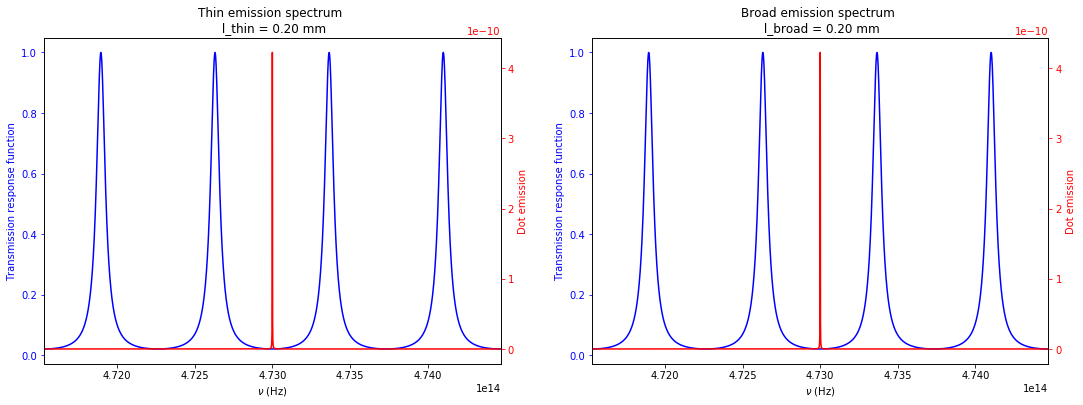

In [182]:
fig, (ax1_thin, ax1_broad) = plt.subplots(1, 2)
fig.set_size_inches(18, 6)

ax1_thin.plot(V_thin, A_prime_trans(V_thin, R_1, R_2, l_thin), "b", label="Transmission Fabry Perot")
ax1_thin.set_xlim(v_boundaries_broad)
ax1_thin.set_xlabel(r"$\nu$ (Hz)")
ax1_thin.set_ylabel("Transmission response function", color="b")
ax1_thin.tick_params("y", colors="b")
ax1_thin.set_title(f"Thin emission spectrum \n l_thin = {l_thin * 10**3:.02f} mm")

ax2_thin = ax1_thin.twinx()
ax2_thin.plot(V_thin, phi_dot_thin, "r", label=r"$\Phi_{dot}(\nu)$")
ax2_thin.set_ylabel("Dot emission", color="r")
ax2_thin.tick_params("y", colors="r")

ax1_broad.plot(V_broad, A_prime_trans(V_broad, R_1, R_2, l_broad), "b", label="Transmission Fabry Perot")
ax1_broad.set_xlim(v_boundaries_broad)
ax1_broad.set_xlabel(r"$\nu$ (Hz)")
ax1_broad.set_ylabel("Transmission response function", color="b")
ax1_broad.tick_params("y", colors="b")
ax1_broad.set_title(f"Broad emission spectrum \n l_broad = {l_broad * 10**3:.02f} mm")

ax2_broad = ax1_broad.twinx()
ax2_broad.plot(V_broad, phi_dot_broad, "r", label=r"$\Phi_{dot}(\nu)$")
ax2_broad.set_ylabel("Dot emission", color="r")
ax2_broad.tick_params("y", colors="r")

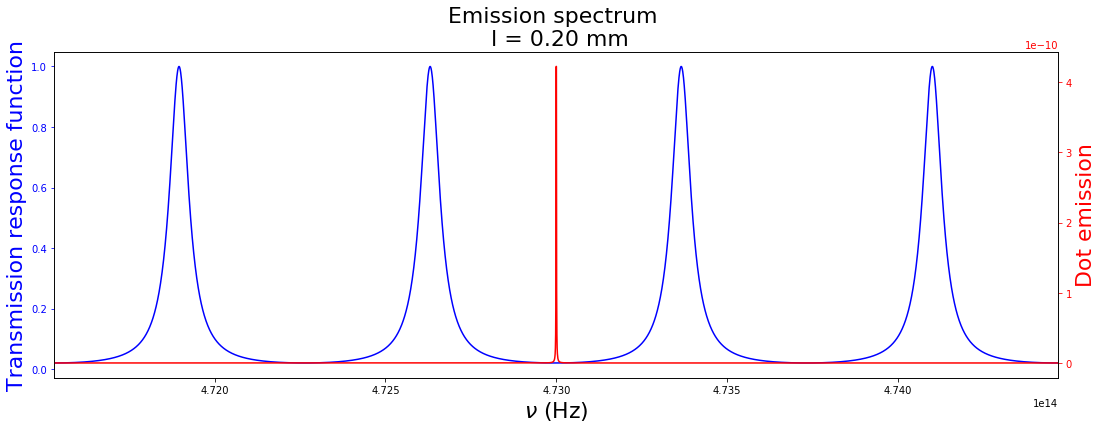

In [190]:
fig, ax1_thin = plt.subplots(1, 1)
fig.set_size_inches(18, 6)

ax1_thin.plot(V_thin, A_prime_trans(V_thin, R_1, R_2, l_thin), "b", label="Transmission Fabry Perot")
ax1_thin.set_xlim(v_boundaries_broad)
ax1_thin.set_xlabel(r"$\nu$ (Hz)", fontsize=22)
ax1_thin.set_ylabel("Transmission response function", color="b", fontsize=22)
ax1_thin.tick_params("y", colors="b")
ax1_thin.set_title(f"Emission spectrum \n l = {l_thin * 10**3:.02f} mm", fontsize=22)

ax2_thin = ax1_thin.twinx()
ax2_thin.plot(V_thin, phi_dot_thin, "r", label=r"$\Phi_{dot}(\nu)$")
ax2_thin.set_ylabel("Dot emission", color="r", fontsize=22)
ax2_thin.tick_params("y", colors="r")

fig.savefig("3.pdf")

The output-photon-flux of the scanning Fabry-Perot-interferometer is described with the convolution of the emission of the QD $E_{dot}(\nu)$ and the transmission of the Fabry-perot $A'_{trans}(\nu)$.

$$\Phi_{fabry,perot, unnormalized} = \int^{v\_dot\_center + \Delta \nu_{FSR} \cdot number\_of\_airy\_peaks}_{v\_dot\_center - \Delta \nu_{FSR} \cdot number\_of\_airy\_peaks} d\nu' E_{dot}(\nu')A'_{trans}(\nu - \nu')$$

it can then be normalized with the integral of $A'_{trans}(\nu)$ over one period:

$$normalization\_factor = \int^{v\_dot\_center + \Delta \nu_{FSR} \cdot number\_of\_airy\_peaks \cdot 0.5}_{v\_dot\_center - \Delta \nu_{FSR} \cdot number\_of\_airy\_peaks \cdot 0.5} d\nu A'_{trans}(\nu) = \frac{\sum A'_{trans}(\nu)}{number\_of\_airy\_peaks} $$

Therefore the output-photon-flux of the scanning Fabry-Perot-interferometer is:
$$\Rightarrow \Phi_{fabry,perot} = \frac{\Phi_{fabry,perot, unnormalized}}{normalization\_factor}$$

In [129]:
def calc_phi_fabry_perot(V, v_dot_center, v_dot_spectral_range, R_1, R_2, l, delta_v_FSR, number_of_airy_peaks):
    phi_fabry_perot_unnormalized = signal.convolve(calc_phi_dot(V, v_dot_center, v_dot_spectral_range), A_prime_trans(V, R_1, R_2, l))
    normalization_factor = sum(A_prime_trans(V, R_1, R_2, l)) / number_of_airy_peaks
    phi_fabry_perot = phi_fabry_perot_unnormalized / normalization_factor

    v_conv_boundaries = (v_dot_center - delta_v_FSR*number_of_airy_peaks, v_dot_center + delta_v_FSR*number_of_airy_peaks)
    V_2 = np.linspace(*v_conv_boundaries, number_of_points*2-1)
    
    return  V_2, phi_fabry_perot

In [130]:
V_2_thin, phi_fabry_perot_thin = calc_phi_fabry_perot(V_thin, v_dot_center, v_dot_spectral_range_thin, R_1, R_2, l_thin, delta_v_FSR_thin, number_of_airy_peaks)
V_2_broad, phi_fabry_perot_broad = calc_phi_fabry_perot(V_broad, v_dot_center, v_dot_spectral_range_broad, R_1, R_2, l_broad, delta_v_FSR_broad, number_of_airy_peaks)

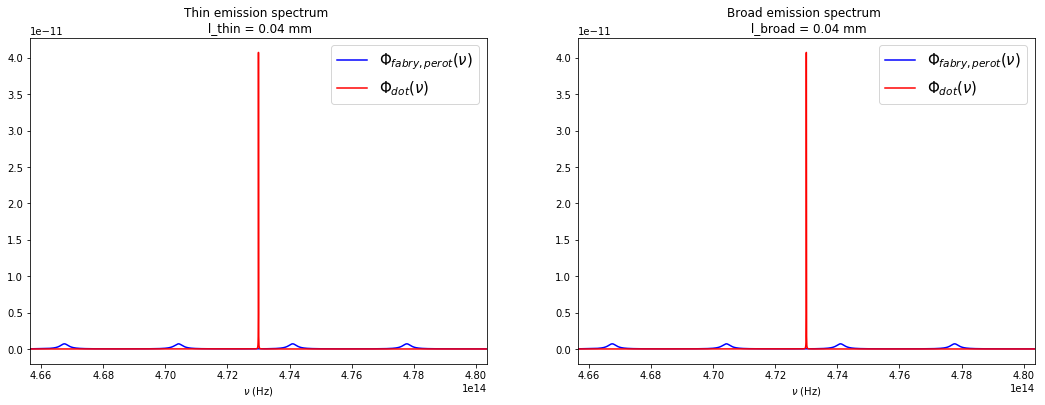

In [131]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(V_2_thin, phi_fabry_perot_thin, "b", label=r"$\Phi_{fabry,perot}(\nu)$")
plt.plot(V_thin, phi_dot_thin, "r" , label=r"$\Phi_{dot}(\nu)$")
plt.xlabel(r"$\nu$ (Hz)")
plt.xlim(v_boundaries_broad)
plt.legend(fontsize=15)
plt.title(f"Thin emission spectrum \n l_thin = {l_thin * 10**3:.02f} mm")

plt.subplot(1, 2, 2)
plt.plot(V_2_broad, phi_fabry_perot_broad, "b", label=r"$\Phi_{fabry,perot}(\nu)$")
plt.plot(V_broad, phi_dot_broad, "r" , label=r"$\Phi_{dot}(\nu)$")
plt.xlabel(r"$\nu$ (Hz)")
plt.xlim(v_boundaries_broad)
plt.legend(fontsize=15)
plt.title(f"Broad emission spectrum \n l_broad = {l_broad * 10**3:.02f} mm")

plt.show()

To better compare $\Phi_{dot}(\nu)$ and $\Phi_{fabry,perot}$, we need to shift them relative to each other:

In [132]:
def shift_phi_fabry_perot(phi_fabry_perot, V, V_2, phi_dot):
    position_V_dot_peak = signal.find_peaks(phi_dot)[0][0]
    position_airy_peaks = signal.find_peaks(phi_fabry_perot)[0]
    
    position_dot_peak = (np.abs(V_2 - V[position_V_dot_peak])).argmin()
    position_closest_airy_peak = position_airy_peaks[(np.abs(V_2[position_airy_peaks] - V[position_V_dot_peak])).argmin()]    
    phi_fabry_perot_shifted = np.roll(phi_fabry_perot, position_dot_peak - position_closest_airy_peak)
    return phi_fabry_perot_shifted, position_dot_peak, position_V_dot_peak

In [133]:
phi_fabry_perot_shifted_thin, position_closest_airy_peak_thin, position_dot_peak_thin  = shift_phi_fabry_perot(phi_fabry_perot_thin, V_thin, V_2_thin, phi_dot_thin)
phi_fabry_perot_shifted_broad, position_closest_airy_peak_broad, position_dot_peak_broad = shift_phi_fabry_perot(phi_fabry_perot_broad, V_broad, V_2_broad, phi_dot_broad)

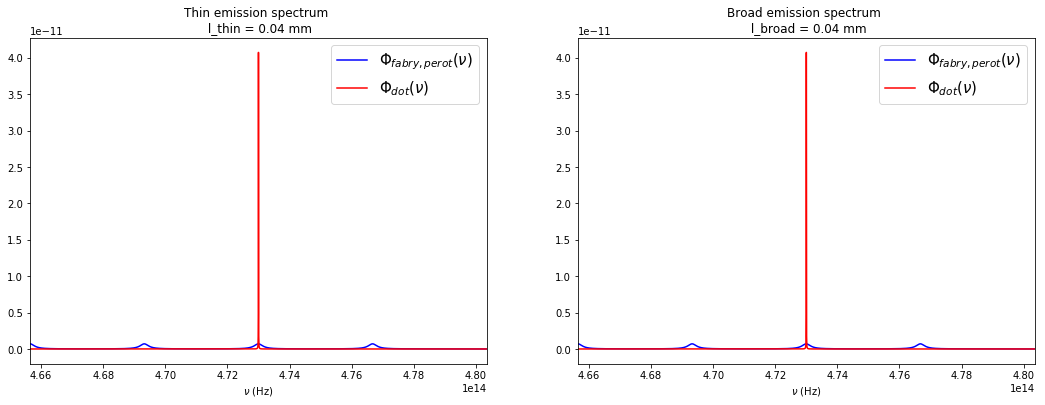

In [134]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(V_2_thin, phi_fabry_perot_shifted_thin, "b", label=r"$\Phi_{fabry,perot}(\nu)$")
plt.plot(V_thin, phi_dot_thin, "r" , label=r"$\Phi_{dot}(\nu)$")
plt.xlabel(r"$\nu$ (Hz)")
plt.xlim(v_boundaries_broad)
plt.legend(fontsize=15)
plt.title(f"Thin emission spectrum \n l_thin = {l_thin * 10**3:.02f} mm")

plt.subplot(1, 2, 2)
plt.plot(V_2_broad, phi_fabry_perot_shifted_broad, "b", label=r"$\Phi_{fabry,perot}(\nu)$")
plt.plot(V_broad, phi_dot_broad, "r" , label=r"$\Phi_{dot}(\nu)$")
plt.xlabel(r"$\nu$ (Hz)")
plt.xlim(v_boundaries_broad)
plt.legend(fontsize=15)
plt.title(f"Broad emission spectrum \n l_broad = {l_broad * 10**3:.02f} mm")


plt.show()

## Calculating Error:

$$ Error = \frac{\int^{v\_dot\_center + \Delta \nu_{FSR} \cdot 0.5}_{v\_dot\_center - \Delta \nu_{FSR} \cdot 0.5} \left|\Phi_{\text{fabry,perot,shifted}}(\nu) - \Phi_{\text{dot}}(\nu)\right| d \nu }{\int^{v\_dot\_center + \Delta \nu_{FSR} \cdot 0.5}_{v\_dot\_center - \Delta \nu_{FSR} \cdot 0.5} \Phi_{\text{dot}}(\nu) d \nu}$$

In terms of indices of V_2 this is equal to boundaries of (number_of_points / number_of_airy_peaks) around the peak of the dot.

In [135]:
def calc_error(phi_fabry_perot_shifted, phi_dot, position_closest_airy_peak, position_dot_peak,  number_of_points, number_of_airy_peaks):
    range_ = (-int(number_of_points / number_of_airy_peaks / 2), int(number_of_points / number_of_airy_peaks / 2))
    boundaries_fabry_perot = position_closest_airy_peak + range_
    boundaries_dot = position_dot_peak + range_
    numerator = np.abs(phi_fabry_perot_shifted[slice(*boundaries_fabry_perot)] - phi_dot[slice(*boundaries_dot)])
    denominator = phi_dot[slice(*boundaries_dot)]
    return numerator, denominator, boundaries_fabry_perot, boundaries_dot

In [136]:
numerator_thin, denominator_thin, boundaries_fabry_perot_thin, boundaries_dot_thin  = calc_error(phi_fabry_perot_shifted_thin, phi_dot_thin, position_closest_airy_peak_thin, position_dot_peak_thin, number_of_points, number_of_airy_peaks)
numerator_broad, denominator_broad, boundaries_fabry_perot_broad, boundaries_dot_broad = calc_error(phi_fabry_perot_shifted_broad, phi_dot_broad, position_closest_airy_peak_broad, position_dot_peak_broad, number_of_points, number_of_airy_peaks)

error_thin = np.sum(numerator_thin) / np.sum(denominator_thin)
error_broad = np.sum(numerator_broad) / np.sum(denominator_broad)

In [137]:
print(f"Error for thin end of the width of the emission spectrum: {error_thin:.2%}")
print(f"Error for broad end of the width of the emission spectrum: {error_broad:.2%}")

Error for thin end of the width of the emission spectrum: 178.42%
Error for broad end of the width of the emission spectrum: 178.42%


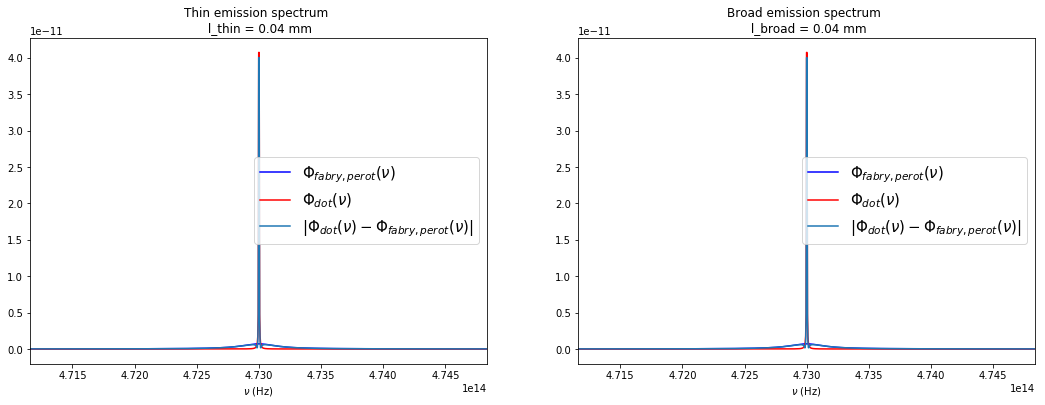

In [138]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(V_2_thin[slice(*boundaries_fabry_perot_thin)], phi_fabry_perot_shifted_thin[slice(*boundaries_fabry_perot_thin)], "b", label=r"$\Phi_{fabry,perot}(\nu)$")
plt.plot(V_thin[slice(*boundaries_dot_thin)], phi_dot_thin[slice(*boundaries_dot_thin)], "r" , label=r"$\Phi_{dot}(\nu)$")
plt.plot(V_thin[slice(*boundaries_dot_thin)], numerator_thin, label=r"$|\Phi_{dot}(\nu) - \Phi_{fabry,perot}(\nu)|$")
plt.xlabel(r"$\nu$ (Hz)")
plt.legend(fontsize=15)
plt.xlim(min(V_broad[slice(*boundaries_dot_broad)]), max(V_broad[slice(*boundaries_dot_broad)]))
plt.title(f"Thin emission spectrum \n l_thin = {l_thin * 10**3:.02f} mm")

plt.subplot(1, 2, 2)
plt.plot(V_2_broad[slice(*boundaries_fabry_perot_broad)], phi_fabry_perot_shifted_broad[slice(*boundaries_fabry_perot_broad)], "b", label=r"$\Phi_{fabry,perot}(\nu)$")
plt.plot(V_broad[slice(*boundaries_dot_broad)], phi_dot_broad[slice(*boundaries_dot_broad)], "r" , label=r"$\Phi_{dot}(\nu)$")
plt.plot(V_broad[slice(*boundaries_dot_broad)], numerator_broad, label=r"$|\Phi_{dot}(\nu) - \Phi_{fabry,perot}(\nu)|$")
plt.xlabel(r"$\nu$ (Hz)")
plt.legend(fontsize=15)
plt.xlim(min(V_broad[slice(*boundaries_dot_broad)]), max(V_broad[slice(*boundaries_dot_broad)]))
plt.title(f"Broad emission spectrum \n l_broad = {l_broad * 10**3:.02f} mm")


plt.show()

## Thermal drift:

### 1) How much does the phase shift with a change of the length between the mirrors $l$?
Investigate case for lower limit of central frequency and upper limit of central frequency

In [139]:
v_dot_center_lower = 4.73 * 10**14 # in Hz
v_dot_center_upper = 4.73 * 10**14 # in Hz

In [140]:
number_of_points = 8000

In [141]:
v_boundaries_lower_thin = (v_dot_center_lower - delta_v_FSR_thin*number_of_airy_peaks/2, v_dot_center_lower + delta_v_FSR_thin*number_of_airy_peaks/2)
v_boundaries_upper_thin = (v_dot_center_upper - delta_v_FSR_thin*number_of_airy_peaks/2, v_dot_center_upper + delta_v_FSR_thin*number_of_airy_peaks/2)

v_boundaries_lower_broad = (v_dot_center_lower - delta_v_FSR_broad*number_of_airy_peaks/2, v_dot_center_lower + delta_v_FSR_broad*number_of_airy_peaks/2)
v_boundaries_upper_broad = (v_dot_center_upper - delta_v_FSR_broad*number_of_airy_peaks/2, v_dot_center_upper + delta_v_FSR_broad*number_of_airy_peaks/2)

V_lower_thin = np.linspace(*v_boundaries_lower_thin, number_of_points)
V_upper_thin = np.linspace(*v_boundaries_upper_thin, number_of_points)

V_lower_broad = np.linspace(*v_boundaries_lower_broad, number_of_points)
V_upper_broad = np.linspace(*v_boundaries_upper_broad, number_of_points)

In [142]:
l_range_lower_thin = np.linspace(0.99, 1, 300) * l_thin
l_range_upper_thin = np.linspace(0.99, 1, 300) * l_thin

l_range_lower_broad = np.linspace(0.99, 1, 300) * l_broad
l_range_upper_broad = np.linspace(0.99, 1, 300) * l_broad

In [143]:
peak_position_lower_thin = np.array([signal.find_peaks(A_prime_trans(V_lower_thin, R_1, R_2, l))[0][0] for l in l_range_lower_thin])
peak_position_upper_thin = np.array([signal.find_peaks(A_prime_trans(V_upper_thin, R_1, R_2, l))[0][0] for l in l_range_upper_thin])

peak_position_lower_broad = np.array([signal.find_peaks(A_prime_trans(V_lower_broad, R_1, R_2, l))[0][0] for l in l_range_lower_broad])
peak_position_upper_broad = np.array([signal.find_peaks(A_prime_trans(V_upper_broad, R_1, R_2, l))[0][0] for l in l_range_upper_broad])

Pick out the first to peaks to determine sweep range over the free spectral range:

In [144]:
sweep_boundaries_lower_thin = signal.find_peaks(peak_position_lower_thin)[0][0:2]
sweep_boundaries_upper_thin = signal.find_peaks(peak_position_upper_thin)[0][0:2]

sweep_boundaries_lower_broad = signal.find_peaks(peak_position_lower_broad)[0][0:2]
sweep_boundaries_upper_broad = signal.find_peaks(peak_position_upper_broad)[0][0:2]

In [145]:
l_sweep_range_lower_thin = l_range_lower_thin[slice(*sweep_boundaries_lower_thin)]
l_sweep_range_upper_thin = l_range_upper_thin[slice(*sweep_boundaries_upper_thin)]

l_sweep_range_lower_broad = l_range_lower_broad[slice(*sweep_boundaries_lower_broad)]
l_sweep_range_upper_broad = l_range_upper_broad[slice(*sweep_boundaries_upper_broad)]

In [146]:
sweep_range_lower_thin = V_lower_thin[peak_position_lower_thin[slice(*sweep_boundaries_lower_thin)]]
sweep_range_upper_thin = V_upper_thin[peak_position_upper_thin[slice(*sweep_boundaries_upper_thin)]]

sweep_range_lower_broad = V_lower_broad[peak_position_lower_broad[slice(*sweep_boundaries_lower_broad)]]
sweep_range_upper_broad = V_upper_broad[peak_position_upper_broad[slice(*sweep_boundaries_upper_broad)]]

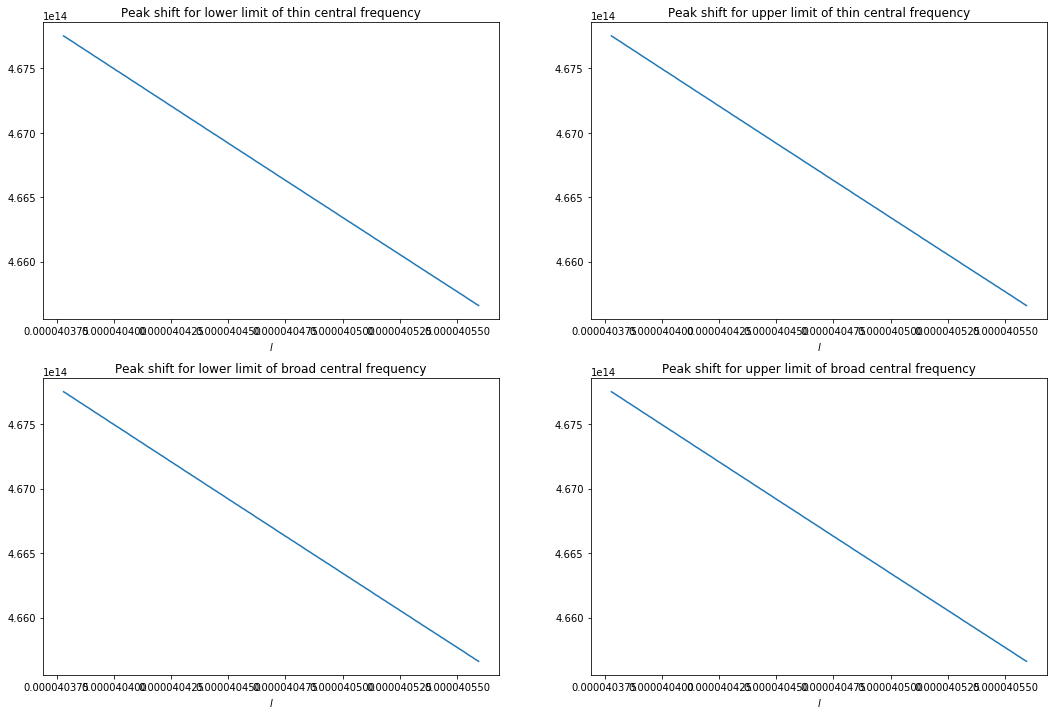

In [147]:
plt.figure(figsize=(18, 12))
plt.subplot(2, 2, 1)
plt.plot(l_sweep_range_lower_thin, sweep_range_lower_thin)
plt.xlabel(r"$l$")
plt.title("Peak shift for lower limit of thin central frequency")

plt.subplot(2, 2, 2)
plt.plot(l_sweep_range_upper_thin, sweep_range_upper_thin)
plt.xlabel(r"$l$")
plt.title("Peak shift for upper limit of thin central frequency")

plt.subplot(2, 2, 3)
plt.plot(l_sweep_range_lower_broad, sweep_range_lower_broad)
plt.xlabel(r"$l$")
plt.title("Peak shift for lower limit of broad central frequency")

plt.subplot(2, 2, 4)
plt.plot(l_sweep_range_upper_broad, sweep_range_upper_broad)
plt.xlabel(r"$l$")
plt.title("Peak shift for upper limit of broad central frequency")
plt.show()

### 2) Calculate $\frac{d\nu}{dl}$

In [148]:
l_sweep_distance_lower_thin = l_sweep_range_lower_thin[-1] - l_sweep_range_lower_thin[0]
l_sweep_distance_upper_thin = l_sweep_range_upper_thin[-1] - l_sweep_range_upper_thin[0]

l_sweep_distance_lower_broad = l_sweep_range_lower_broad[-1] - l_sweep_range_lower_broad[0]
l_sweep_distance_upper_broad = l_sweep_range_upper_broad[-1] - l_sweep_range_upper_broad[0]

In [149]:
print(f"l_sweep_lower_thin:  {l_sweep_distance_lower_thin * 10**9:.02f} nm")
print(f"l_sweep_upper_thin:  {l_sweep_distance_upper_thin * 10**9:.02f} nm")
print(f"l_sweep_lower_broad: {l_sweep_distance_lower_broad * 10**9:.02f} nm")
print(f"l_sweep_upper_broad: {l_sweep_distance_upper_broad * 10**9:.02f} nm")

l_sweep_lower_thin:  181.42 nm
l_sweep_upper_thin:  181.42 nm
l_sweep_lower_broad: 181.42 nm
l_sweep_upper_broad: 181.42 nm


In [150]:
dv_dl_lower_thin = (sweep_range_lower_thin[-1] - sweep_range_lower_thin[0])/(l_sweep_distance_lower_thin)
dv_dl_upper_thin = (sweep_range_upper_thin[-1] - sweep_range_upper_thin[0])/(l_sweep_distance_upper_thin)

dv_dl_lower_broad = (sweep_range_lower_broad[-1] - sweep_range_lower_broad[0])/(l_sweep_distance_lower_broad)
dv_dl_upper_broad = (sweep_range_upper_broad[-1] - sweep_range_upper_broad[0])/(l_sweep_distance_upper_broad)

In [151]:
print(f"dv_dl_lower_thin: {dv_dl_lower_thin:.02} Hz/m")
print(f"dv_dl_upper_thin: {dv_dl_upper_thin:.02} Hz/m")
print(f"dv_dl_lower_broad: {dv_dl_lower_broad:.02} Hz/m")
print(f"dv_dl_upper_broad: {dv_dl_upper_broad:.02} Hz/m")

dv_dl_lower_thin: -1.2e+19 Hz/m
dv_dl_upper_thin: -1.2e+19 Hz/m
dv_dl_lower_broad: -1.2e+19 Hz/m
dv_dl_upper_broad: -1.2e+19 Hz/m


In [152]:
print(f"relative_error_lower_thin: {dv_dl_lower_thin / delta_v_FSR_thin * 10**(-9):.02%} /nm")
print(f"relative_error_upper_thin: {dv_dl_upper_thin / delta_v_FSR_thin * 10**(-9):.02%} /nm")
print(f"relative_error_lower_broad: {dv_dl_lower_broad / delta_v_FSR_broad * 10**(-9):.02%} /nm")
print(f"relative_error_upper_broad: {dv_dl_upper_broad / delta_v_FSR_broad * 10**(-9):.02%} /nm")

relative_error_lower_thin: -0.31% /nm
relative_error_upper_thin: -0.31% /nm
relative_error_lower_broad: -0.31% /nm
relative_error_upper_broad: -0.31% /nm


$\Rightarrow$ relative error and l_sweep depend only on the central wavelength